# AB Comb Polymers in Potential Fields

This script demonstrates how to compute single partition functions and concentrations of AB Comb polymers for given potential fields.

### 1. Import python modules and set environment variables

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import polymerfts

# OpenMP environment variables
os.environ["MKL_NUM_THREADS"] = "1"  # always 1
os.environ["OMP_STACKSIZE"] = "1G"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"  # 0, 1
os.environ["OMP_NUM_THREADS"] = "2"  # 1 ~ 4

# GPU environment variables
os.environ["LFTS_GPU_NUM_BLOCKS"]  = "256"
os.environ["LFTS_GPU_NUM_THREADS"] = "256"
os.environ["LFTS_NUM_GPUS"] = "1" # 1 ~ 2

### 2. Setup some simulation parameters

\begin{align}
N &= 100 \\
\Delta s &= 1/N = 0.01 \\
L_x &= 5.0 bN^{1/2} \\
L_y &= 5.0 bN^{1/2} \\
V &= L_x L_y \\ 
m_x &= 64 \\
m_y &= 64 \\
b_A/b &= 1.0 \\
b_B/b &= 1.0 \\  
\end{align}

In numerical computation, $b^2N = 1$.

In [2]:
# Simulation parameters
nx = [64,64]                       # grid number
lx = [5.0,5.0]                     # box size
stat_seg_lengths = {"A":1.0,       # statistical segment lengths
                    "B":1.0}       
ds = 0.01                          # contour step interval

### 3. Create a factory

* The factory will create the following instances for chosen platform and data-type.
    * simulation_box
    * molecules
    * propagator_computation_optimizer
    * solver

In [3]:
# Select platform ("cuda" or "cpu-mkl") and data-type ("real" or "complex")
reduce_gpu_memory_usage = False
factory = polymerfts.PlatformSelector.create_factory("cpu-mkl", reduce_gpu_memory_usage, "real")
factory.display_info()

==================== MKL Version ====================
Major version:           2021
Minor version:           0
Update version:          4
Product status:          Product
Build:                   20210904
Platform:                Intel(R) 64 architecture
Processor optimization:  Intel(R) Architecture processors


In [4]:
# Create an instance for computation box
cb = factory.create_computation_box(nx, lx) 
# Create an instance for molecule information with block segment information and chain model ("continuous" or "discrete")
molecules = factory.create_molecules_information("continuous", ds, stat_seg_lengths)

### 4. Add comb polymers

The backbone length is 1.0 with A-type monomers.
There are 3 side chains, whose monomer type is B and each length is 0.5.
Block lengths for A and B blocks are $f_A=0.5$ and $f_B=0.5$.

In [5]:
# Add AB diblock copolymers
volume_fraction = 1.0
blocks = [["A", 0.5, 0, 1],
          ["A", 0.5, 1, 2],
          ["B", 0.5, 0, 3],
          ["B", 0.5, 1, 4],
          ["B", 0.5, 2, 5],
          ]
molecules.add_polymer(volume_fraction, blocks)

### 5. Analyze graphs and optimize the computations

Remove the redundent computations and aggregate propagators of multiple side chains.

Reference: [Dynamic Programming for Chain Propagator Computation of Branched Block Copolymers in Polymer Field Theory Simulations](https://doi.org/10.1021/acs.jctc.5c00103)

In [6]:
# Optimizer to avoid redundant computations
aggregate_propagator_computation = True
propagator_computation_optimizer = factory.create_propagator_computation_optimizer(molecules, aggregate_propagator_computation)
propagator_computation_optimizer.display_blocks()
propagator_computation_optimizer.display_propagators()

--------------- Blocks ---------------
Polymer id, left key:
	aggregated, (left, right) is_junction, (left, right) n_segment, right key, n_repeat, {v, u} list

0, (B50)A:
	 X, (O, O), (50, 50), ((B50)A50B50)A, 2, {0,1}, {2,1}

0, B:
	 X, (X, O), (50, 0), (((B50)A50B50)A50)B, 2, {3,0}, {5,2}
	 X, (X, O), (50, 0), ((B50)A50(B50)A50)B, 1, {4,1}
	 O, (X, O), (50, 50), [(((B50)A50B50)A50)B0:2,((B50)A50(B50)A50)B0]B, 1, {3,0}, {5,2}, {4,1}
--------------- Propagators ---------------
Key:
	height, aggregated, max_n_segment, # dependencies, junction_ends
B:
	 0, X, 50, 0, {50}, 
(B50)A:
	 1, X, 50, 1, {50}, 
((B50)A50B50)A:
	 2, X, 50, 2, {50}, 
((B50)A50(B50)A50)B:
	 2, X, 0, 2, {}, 
(((B50)A50B50)A50)B:
	 3, X, 0, 1, {}, 
[(((B50)A50B50)A50)B0:2,((B50)A50(B50)A50)B0]B:
	 4, O, 50, 2, {}, 
Total number of modified diffusion equation steps (time complexity) to compute propagators: 500
Total number of steps after optimizing computation : 200
Computational cost reduction (higher is better) : 60 

### 5. Set Potential fields

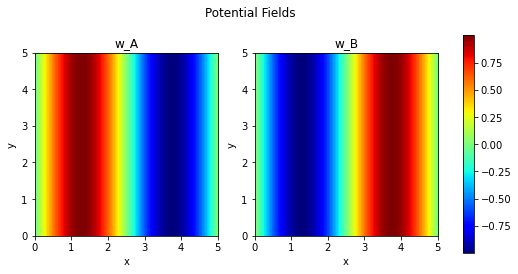

In [7]:
w_A =  np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for A
w_B = -np.tile(np.sin(np.linspace(0, 2*np.pi, nx[0])), (nx[1], 1))   # sinusoidal potential field for B
w = {"A": w_A, "B": w_B}  # potential field dictionary

# Plot each image with the same vmin and vmax
vmin = min(w_A.min(), w_B.min())
vmax = max(w_A.max(), w_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Potential Fields")
im = axes[0].imshow(w_A, extent=(0, lx[0], 0, lx[1]), origin="lower", cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(w_B, extent=(0, lx[0], 0, lx[1]), origin="lower", cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='w_A', xlabel='x', ylabel='y')
axes[1].set(title='w_B', xlabel='x', ylabel='y')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()

### 6. Solving the modified diffusion equations and compute single chain partition function

The propagators for A-type block, $(v,t) \in \{(0,1),(1,2),(1,0),(2,1)\}$ :
\begin{align}
\left[-\frac{\partial}{\partial s} + \frac{b_A^2}{6}\nabla^2 - w_A({\bf r})\right] q^{v \rightarrow t}_0({\bf r}, s)=0,\ \ \ \ \ s\in [0, f_A]
\end{align}

The propagators for B-type block in forward direction, $(v,t) \in \{(3,0),(4,1),(5,2)\}$ :
\begin{align}
\left[-\frac{\partial}{\partial s} + \frac{b_B^2}{6}\nabla^2 - w_B({\bf r})\right] q^{v \rightarrow t}_0({\bf r}, s)=0,\ \ \ \ \ s\in [0, f_B]
\end{align}

The propagators for B-type block in backward direction with aggregation:
\begin{align}
\left[-\frac{\partial}{\partial s} + \frac{b_B^2}{6}\nabla^2 - w_B({\bf r})\right] \left[q^{0 \rightarrow 3}_0({\bf r}, s)+q^{1 \rightarrow 4}_0({\bf r}, s)+q^{2 \rightarrow 5}_0({\bf r}, s) \right]=0,\ \ \ \ \ s\in [0, f_B]
\end{align}

Single chain partition function:
\begin{align}
Q_0 = \frac{1}{V}\int d{\bf r}\ q^{0 \rightarrow 1}_0({\bf r}, s)q^{1 \rightarrow 0}_0({\bf r}, f_A-s) 
\end{align}

In [8]:
# Create a solver
solver = factory.create_pseudospectral_solver(cb, molecules, propagator_computation_optimizer)

# Compute Propagators (q) and single partition function (Q)
solver.compute_propagators({"A":w["A"], "B":w["B"]})

# Single partition function
Q = solver.get_total_partition(0)
print(f"Q:", Q)

Q: 1.0544084655657844


### 7. Compute concentrations

\begin{align}
\phi_A({\bf r}) &= \frac{1}{Q_0} \sum_{(v,u)\in\{(0,1),(1,2)\}} \int_{0}^{f_A} ds\ q^{v \rightarrow u}_0({\bf r}, s)q^{u \rightarrow v}_0({\bf r}, f_A-s) \\
\phi_B({\bf r}) &= \frac{1}{Q_0} \sum_{(v,u)\in\{(0,3),(1,4),(2,5)\}} \int_{0}^{f_B} ds\ q^{v \rightarrow u}_0({\bf r}, s)q^{u \rightarrow v}_0({\bf r}, f_B-s) \\
                &= \frac{1}{Q_0} \int_{0}^{f_B} ds\ \left[q^{0 \rightarrow 3}_0({\bf r}, s)+q^{1 \rightarrow 4}_0({\bf r}, s)+q^{2 \rightarrow 5}_0({\bf r}, s) \right] q^{3 \rightarrow 0}_0({\bf r}, f_B-s) 
\end{align}

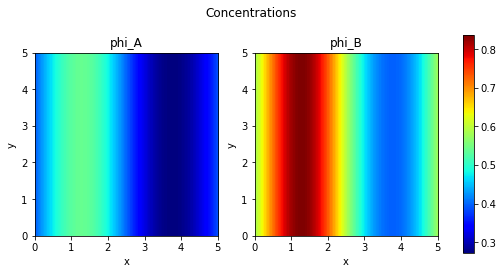

In [9]:
# Compute ensemble average concentration (phi)
solver.compute_concentrations()

# Get the ensemble average concentration for each monomer type
phi_A = np.reshape(solver.get_total_concentration("A"), nx)
phi_B = np.reshape(solver.get_total_concentration("B"), nx)

# Plot each image with the same vmin and vmax
vmin = min(phi_A.min(), phi_B.min())
vmax = max(phi_A.max(), phi_B.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle("Concentrations")
im = axes[0].imshow(phi_A, extent=(0, lx[0], 0, lx[1]), origin="lower", cmap=cm.jet, vmin=vmin, vmax=vmax)
im = axes[1].imshow(phi_B, extent=(0, lx[0], 0, lx[1]), origin="lower", cmap=cm.jet, vmin=vmin, vmax=vmax)
axes[0].set(title='phi_A', xlabel='x', ylabel='y')
axes[1].set(title='phi_B', xlabel='x', ylabel='y')

fig.subplots_adjust(right=1.0)
fig.colorbar(im, ax=axes.ravel().tolist())
fig.show()

### 8. Access the propagators

The following propagators are not accessible, since they are aggregated.

* $q^{0 \rightarrow 3}_0({\bf r}, s)$
* $q^{1 \rightarrow 4}_0({\bf r}, s)$
* $q^{2 \rightarrow 5}_0({\bf r}, s)$

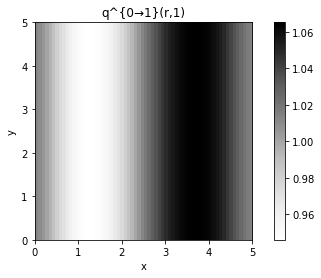

RuntimeError: File: "/home/yongdd/polymer/langevin-fts/src/pybind11/polymerfts_core.cpp", line: 293, function <operator()>
	File: "/home/yongdd/polymer/langevin-fts/src/platforms/cpu/CpuComputationContinuous.cpp", function <get_chain_propagator>
	File: "/home/yongdd/polymer/langevin-fts/src/platforms/cpu/CpuComputationContinuous.cpp", line: 780, function <get_chain_propagator>
	n (50) must be in range [0, 0]

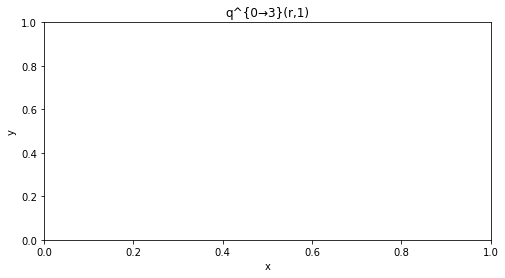

In [10]:
import matplotlib.animation as animation

# A-type chain propagators
p,v,u=(0, 0, 1)

plt.figure(figsize=(8, 4))
plt.title('q^{0→1}(r,1)')
plt.xlabel('x')
plt.ylabel('y')
data = np.reshape(solver.get_chain_propagator(p, v, u, 50), nx)
plt.imshow(data, extent=(0, lx[0], 0, lx[1]), cmap=cm.Greys)  # , interpolation='nearest',
plt.colorbar()
plt.show()

# B-type chain propagators
p,v,u=(0, 0, 3)

plt.figure(figsize=(8, 4))
plt.title('q^{0→3}(r,1)')
plt.xlabel('x')
plt.ylabel('y')
data = np.reshape(solver.get_chain_propagator(p, v, u, 50), nx) # This cause runtime error
plt.imshow(data, extent=(0, lx[0], 0, lx[1]), cmap=cm.Greys)
plt.colorbar()
plt.show()